In [1]:
from KerasSeq2Seq import DeepSeq2SeqModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


This implimentation was written with time-series in mind (though the same thing applies to other sequence types, nlp etc.), so lets make a simple time dependent data-set.

In [2]:
N_SAMPLES = 5000
IN_LENGTH = 100
OT_LENGTH = 50

In [3]:
x = np.linspace(0, 200*np.pi, N_SAMPLES)
noise = 0.1*np.random.normal(size=N_SAMPLES)
f = 0.5*np.sin(x)+noise

We'll look at the problem of predicting the next part of a noisy sin-wave given the previous steps. Overall the time-series looks like

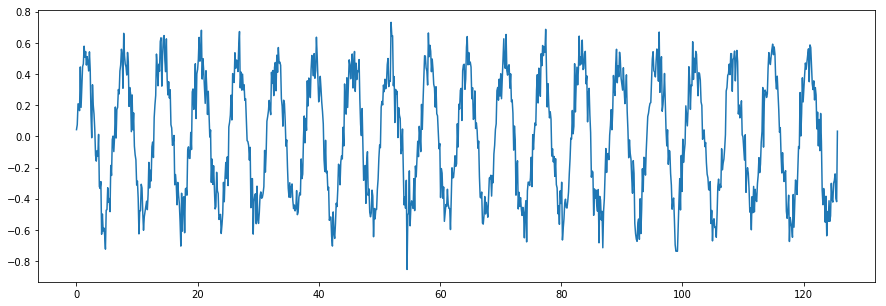

In [4]:
plt.figure(figsize=(15,5))
plt.plot(x[:1000], f[:1000]);

The samples need to be in the shape **SAMPLES x STEPS x FEATURES**

In [5]:
X = []
Y = []

for i in range(0, N_SAMPLES-(IN_LENGTH+OT_LENGTH)):
    X.append(f[i: i+IN_LENGTH])
    Y.append(f[i+IN_LENGTH: i+(IN_LENGTH+OT_LENGTH)])
    
X = np.expand_dims(np.vstack(X), axis=2)
Y = np.expand_dims(np.vstack(Y), axis=2)

X, Y = shuffle(X, Y)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [7]:
print('X Train Shape:\t {}'.format(x_train.shape))
print('X Test Shape:\t {}'.format(x_test.shape))
print('Y Train Shape:\t {}'.format(y_train.shape))
print('Y Test Shape:\t {}'.format(y_test.shape))

X Train Shape:	 (4365, 100, 1)
X Test Shape:	 (485, 100, 1)
Y Train Shape:	 (4365, 50, 1)
Y Test Shape:	 (485, 50, 1)


The model takes the shape of individual examples as parameters, along with lists assigning the dimension of each hidden layer in the encoder and decoder networks

In [8]:
mdl = DeepSeq2SeqModel(x_train.shape[1:], y_train.shape[1:], [4, 4], [4, 4])

In [9]:
mdl.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, None, 4)      84          dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, None, 4)      0           cu_dnngru_1[0][0]                
__________________________________________________________________________________________________
input_2 (I

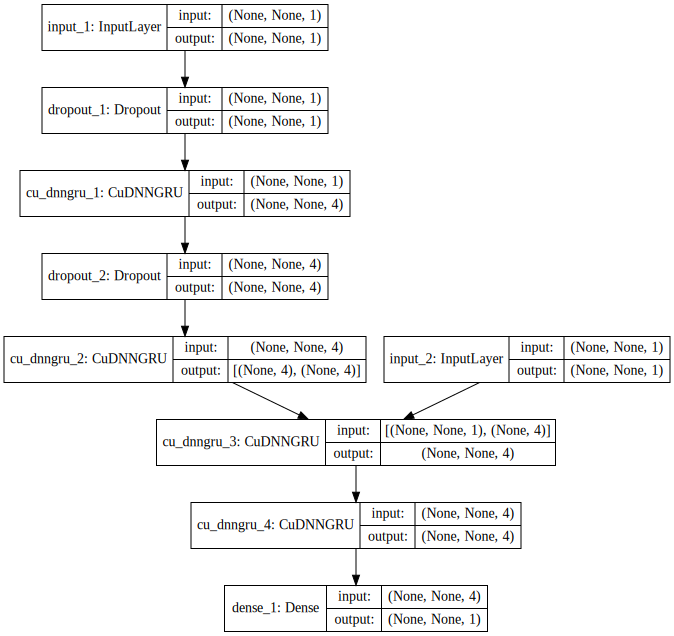

In [10]:
SVG(model_to_dot(mdl.model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
history = mdl.train(x_train, y_train, verbose=0)

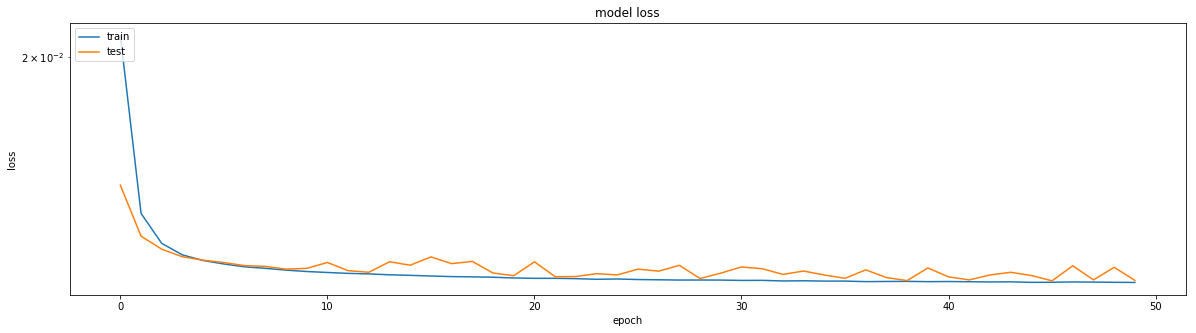

In [12]:
plt.figure(figsize=(20, 5))
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

Once the model is trained it can be then used to predict the series from the previous states

In [13]:
predictions = mdl.predict(x_test[:5])

Building prediction decoder network
Running predictions


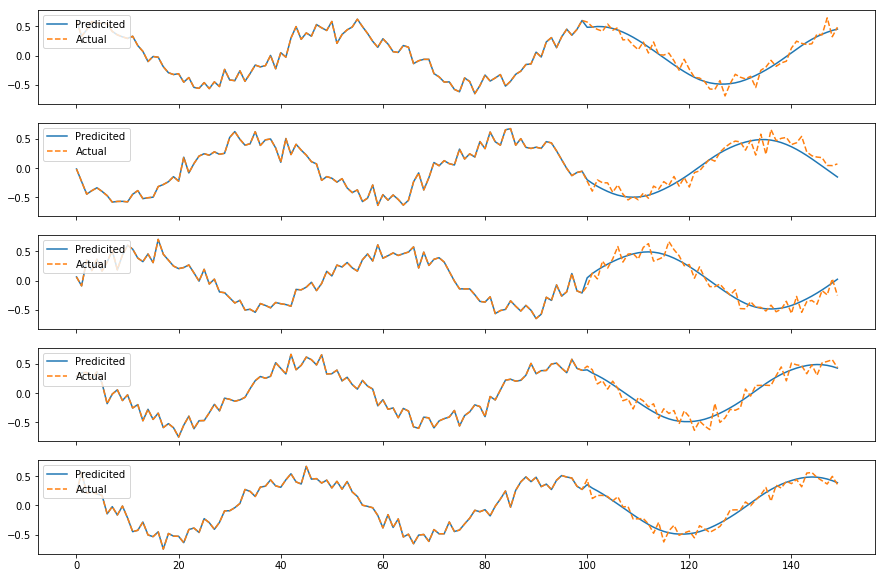

In [14]:
f, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(15, 10))

for i in range(5):
    ax[i].plot(np.concatenate([x_test[i], predictions[i]]), label='Predicited')
    ax[i].plot(np.concatenate([x_test[i], y_test[i]]), linestyle='--', label='Actual')
    ax[i].legend(loc="upper left")

plt.show();